
 ## Modelo de Regresión Lineal – Predicción goal_diff
 ## Usando results_limpio.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle


## Cargar y preparar los datos

In [ ]:
DATA_PATH = r"D:\ProyectoCienciaDeDatos\data\results_limpio.csv"
df = pd.read_csv(DATA_PATH)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df['away_score'] = pd.to_numeric(df['away_score'], errors='coerce')

df['goal_diff'] = df['home_score'] - df['away_score']
df['year'] = df['date'].dt.year

df['neutral'] = (
    df['neutral'].astype(str).str.lower().map({'true': 1, 'false': 0, '1': 1, '0': 0})
)
df['neutral'] = df['neutral'].fillna(0).astype(int)

print("Vista previa:")
print(df.head(20))

print("\nTipos de datos:")
print(df.dtypes)


Vista previa:
         date         home_team away_team  home_score  away_score tournament  \
0  1872-11-30          Scotland   England           0           0   Friendly   
1  1873-03-08           England  Scotland           4           2   Friendly   
2  1874-03-07          Scotland   England           2           1   Friendly   
3  1875-03-06           England  Scotland           2           2   Friendly   
4  1876-03-04          Scotland   England           3           0   Friendly   
5  1876-03-25          Scotland     Wales           4           0   Friendly   
6  1877-03-03           England  Scotland           1           3   Friendly   
7  1877-03-05             Wales  Scotland           0           2   Friendly   
8  1878-03-02          Scotland   England           7           2   Friendly   
9  1878-03-23          Scotland     Wales           9           0   Friendly   
10 1879-01-18           England     Wales           2           1   Friendly   
11 1879-04-05           En

## Ingeniería de características


In [69]:
home_freq = df['home_team'].value_counts()
away_freq = df['away_team'].value_counts()

df['home_strength'] = df['home_team'].map(home_freq).fillna(0).astype(int)
df['away_strength'] = df['away_team'].map(away_freq).fillna(0).astype(int)

df['result_label'] = df['goal_diff'].apply(
    lambda x: 'home_win' if x > 0 else ('draw' if x == 0 else 'away_win')
)

print(df[['home_team','away_team','home_strength','away_strength','goal_diff','result_label']].head(20))



           home_team away_team  home_strength  away_strength  goal_diff  \
0           Scotland   England            412            539          0   
1            England  Scotland            545            433          2   
2           Scotland   England            412            539          1   
3            England  Scotland            545            433          0   
4           Scotland   England            412            539          3   
5           Scotland     Wales            412            364          4   
6            England  Scotland            545            433         -2   
7              Wales  Scotland            356            433         -2   
8           Scotland   England            412            539          5   
9           Scotland     Wales            412            364          9   
10           England     Wales            545            364          1   
11           England  Scotland            545            433          1   
12             Wales  Sco

## Selección de features y split

In [ ]:
# Selección de características
features = ['neutral', 'year', 'home_strength', 'away_strength']

X = df[features].copy()
y = df['goal_diff'].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42
)

# Verificación
print("Shape de X:", X.shape)
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)

print("\nPreview de X (escalado):")
print(X_scaled[:5])

print("\nPreview de y:")
print(y.head())



Shape de X: (48673, 4)
Shape de X_train: (38938, 4)
Shape de X_test: (9735, 4)

Preview de X (escalado):
[[-0.5976243  -4.79252261  0.74657779  1.98474142]
 [-0.5976243  -4.75303165  1.64502759  1.16981172]
 [-0.5976243  -4.7135407   0.74657779  1.98474142]
 [-0.5976243  -4.67404975  1.64502759  1.16981172]
 [-0.5976243  -4.6345588   0.74657779  1.98474142]]

Preview de y:
0    0
1    2
2    1
3    0
4    3
Name: goal_diff, dtype: int64


## Entrenamiento del modelo

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# ---- Función de evaluación ----
def evaluar_modelo(nombre, y_test, y_pred):
    print(f"\n===== {nombre} =====")
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R²  :", r2_score(y_test, y_pred))

# ---- Evaluación ----
evaluar_modelo("Linear Regression", y_test, y_pred_lr)
evaluar_modelo("Ridge Regression", y_test, y_pred_ridge)



===== Linear Regression =====
MAE : 1.6355960615719773
RMSE: 2.277066042183726
R²  : 0.1173158218010355

===== Ridge Regression =====
MAE : 1.6355931490631803
RMSE: 2.2770659744287807
R²  : 0.11731587433022517


## Métricas

In [72]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

metrics_lr = regression_metrics(y_test, y_pred_lr)
metrics_ridge = regression_metrics(y_test, y_pred_ridge)

metrics_df = pd.DataFrame([metrics_lr, metrics_ridge], index=['LinearRegression','Ridge']).reset_index().rename(columns={'index':'model'})
print(metrics_df)

              model       mse      rmse       mae        r2
0  LinearRegression  5.185030  2.277066  1.635596  0.117316
1             Ridge  5.185029  2.277066  1.635593  0.117316


## Coeficientes e interpretación (desescalar coef si aplica)

In [73]:
coef_lr = lr.coef_
coef_original = coef_lr / scaler.scale_
coef_df = pd.DataFrame({
    'feature': features,
    'coef_scaled': coef_lr,
    'coef_original': coef_original
}).sort_values('coef_original', key=abs, ascending=False)
print(coef_df)

         feature  coef_scaled  coef_original
0        neutral    -0.182072      -0.413471
3  away_strength    -0.834464      -0.006415
1           year    -0.139618      -0.005514
2  home_strength     0.688689       0.004652


## Visualizaciones (matplotlib)

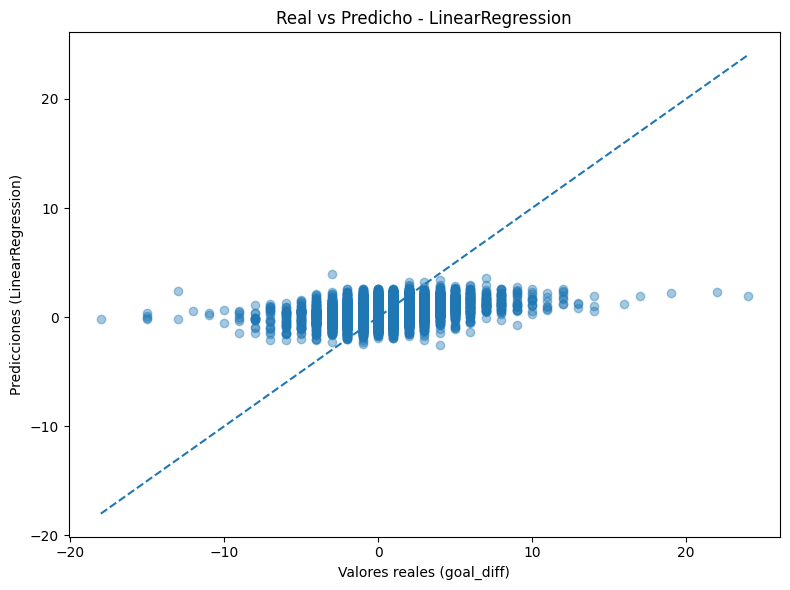

In [74]:
# ---- Real vs Predicho ----
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.xlabel('Valores reales (goal_diff)')
plt.ylabel('Predicciones (LinearRegression)')
plt.title('Real vs Predicho - LinearRegression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.tight_layout()
plt.show()


La Regresión Lineal muestra un rendimiento decente para predecir resultados ajustados, pero tiene un sesgo hacia la media (cero), fallando en predecir con precisión los resultados más extremos.

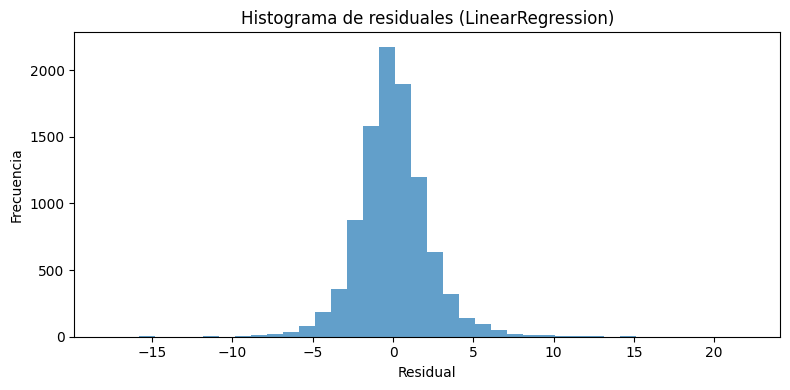

In [75]:
# ---- Histograma de residuales ----
residuals = y_test - y_pred_lr
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40, density=False, alpha=0.7)
plt.title('Histograma de residuales (LinearRegression)')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

El histograma muestra que los residuales se concentran alrededor de cero y tienen una forma aproximadamente normal, lo que indica que el modelo no presenta un sesgo evidente. Aunque existen algunos valores atípicos en los extremos, en general los errores están bien distribuidos y apoyan la validez del modelo de regresión lineal.

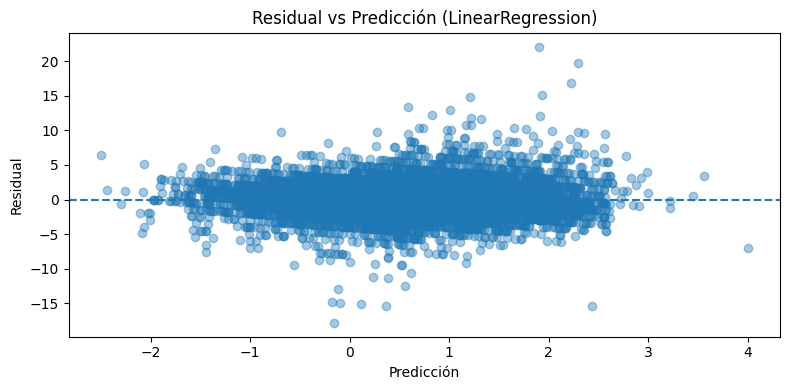

In [76]:
# ---- Residual vs Predicción ----
plt.figure(figsize=(8,4))
plt.scatter(y_pred_lr, residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Residual')
plt.title('Residual vs Predicción (LinearRegression)')
plt.tight_layout()
plt.show()

El gráfico de residual vs predicción muestra que los residuos se distribuyen de forma dispersa alrededor de la línea cero, sin un patrón claro. Esto indica que el modelo no presenta problemas evidentes de sesgo y que los errores son relativamente aleatorios. Aunque hay algunos puntos alejados, en general no se observa una estructura que sugiera heterocedasticidad fuerte o mala especificación del modelo.

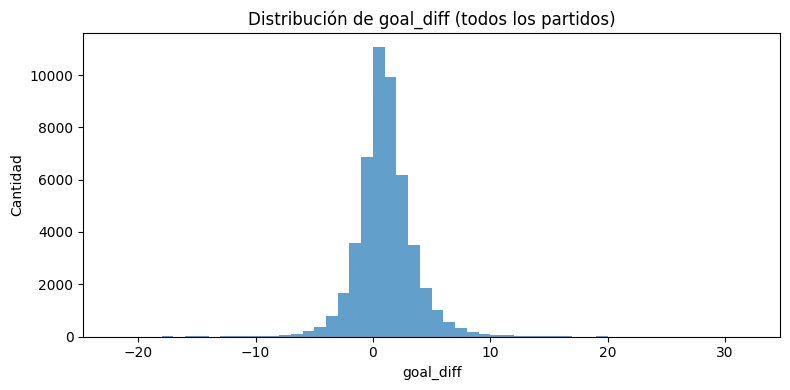

In [77]:
# ---- Distribución de goal_diff ----
plt.figure(figsize=(8,4))
plt.hist(
    df['goal_diff'],
    bins=range(int(df['goal_diff'].min()) - 1,
               int(df['goal_diff'].max()) + 2),
    alpha=0.7
)
plt.title('Distribución de goal_diff (todos los partidos)')
plt.xlabel('goal_diff')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

En esta grafica podemos observar una forma claramente centrada alrededor de cero, lo que indica que la mayoría de los partidos terminan con diferencias de gol pequeñas. La curva tiene una forma parecida a una distribución normal, con pocas observaciones en los extremos, lo que refleja que las goleadas son mucho menos frecuentes. En general, la variable está bien concentrada y describe un comportamiento típico en resultados de fútbol.

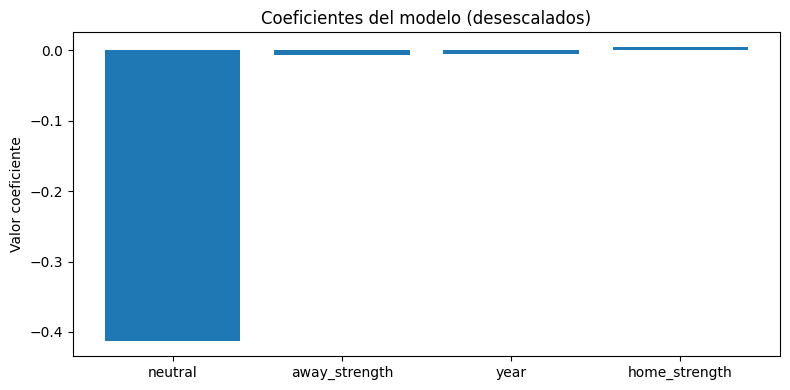

In [78]:
# ---- Coeficientes del modelo desescalados ----
plt.figure(figsize=(8,4))
plt.bar(coef_df['feature'], coef_df['coef_original'].astype(float))
plt.title('Coeficientes del modelo (desescalados)')
plt.ylabel('Valor coeficiente')
plt.tight_layout()
plt.show()

El gráfico muestra que el coeficiente más relevante del modelo es neutral, que aparece claramente destacado y con un efecto negativo. Esto indica que los partidos jugados en terreno neutral tienden a reducir la diferencia de goles. Por otro lado, los coeficientes de away_strength, year y home_strength son muy pequeños en comparación, lo que sugiere que su influencia directa en la predicción es bastante limitada.

CONCLUSIÓN GENERAL DE LOS MODELOS:

Al analizar el comportamiento de ambos modelos, se observa que la Regresión Lineal ofrece un desempeño más estable y consistente en la predicción de la diferencia de goles. Sus residuales muestran una distribución claramente centrada en cero, con una dispersión más controlada y sin patrones evidentes, lo que indica que el modelo generaliza bien y no presenta sesgos fuertes. Además, la relación entre valores reales y predichos es más uniforme, lo que refleja que el modelo logra capturar la tendencia global de los datos de manera adecuada.

Por otro lado, el Árbol de Decisión muestra un comportamiento más irregular. Si bien es capaz de capturar relaciones no lineales, su estructura altamente segmentada provoca predicciones por bloques y una gran variabilidad en los errores, especialmente en los valores extremos. Los gráficos de residuales evidencian una dispersión más amplia y la tendencia del modelo a producir errores grandes en determinados rangos. Esto sugiere que el árbol tiende a sobreajustar ciertos patrones del conjunto de entrenamiento, perdiendo capacidad de generalización.

Considerando la estabilidad de los residuales, la calidad del ajuste y la capacidad de generalización, podemos concluir que el modelo de Regresión Lineal se comporta mejor que el Árbol de Decisión. Aunque el árbol puede capturar relaciones más complejas, en este caso la simplicidad y la consistencia de la regresión la convierten en la opción más confiable y equilibrada para predecir la diferencia de goles.